# National-level analysis: Figure 4

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib import gridspec

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'
plt.rcParams['mathtext.rm'] = 'Avenir'
plt.rcParams['mathtext.it'] = 'Avenir:italic'
plt.rcParams['mathtext.bf'] = 'Avenir:bold'
plt.rcParams['font.size'] = 22
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['pdf.fonttype'] = 42

## Figure 4

In [4]:
# Get both ensembles
from combine import combine_nex, combine_cmip
nex_all = combine_nex()
cmip_all = combine_cmip()

In [36]:
# Construct national weights (total production by weighted sum of counties)
weights = pd.read_csv('../usda/output/USDA_county_yields_w_county_quad_trends.csv').filter(["GEOID", "year", "area","yield"])
weights["GEOID"] = weights["GEOID"].astype(str).str.zfill(5)
weights.sort_values(by = ['GEOID', 'year'], inplace = True)
weights.set_index(['GEOID', 'year'], inplace = True)
weights["national_weight"] = weights["area"] * weights["yield"]
weights_norm = weights.groupby("year").sum().drop(columns = ["yield", "area"])
# Normalise
weights = pd.merge(weights.reset_index().filter(["GEOID","year","national_weight"]), weights_norm, on = "year")
weights["national_weight"] = weights["national_weight_x"] / weights["national_weight_y"]
weights.drop(columns = ["national_weight_x", "national_weight_y"],inplace=True)
weights = weights.set_index(['GEOID','year']).sort_index()
weights = weights.filter(['national_weight'])

In [38]:
# Interquartile range
def get_iqr(dat):
    return np.quantile(dat, 0.75) - np.quantile(dat, 0.25)

# Silverman bandwidth estimate
def silverman(dat):
    return 0.9 * np.min([np.std(dat), get_iqr(dat)/1.34]) * len(dat)**-0.2

In [54]:
# Yield (weighted by production)
nex_weighted = pd.merge(nex_all, weights.reset_index(), left_on = ['GEOID','Year'], right_on = ['GEOID','year'], how = 'inner').drop(columns = ['year'])
for model in nex_weighted.columns[2:-1]:
    nex_weighted[model] = nex_weighted[model] * nex_weighted['national_weight']
nex_weighted = nex_weighted.groupby(['Year']).sum()

cmip_weighted = pd.merge(cmip_all, weights.reset_index(), left_on = ['GEOID','Year'], right_on = ['GEOID','year'], how = 'inner').drop(columns = ['year'])
for model in cmip_weighted.columns[2:-1]:
    cmip_weighted[model] = cmip_weighted[model] * cmip_weighted['national_weight']
cmip_weighted = cmip_weighted.groupby(['Year']).sum()

# Ensembles
NEXens_w = nex_weighted.drop(columns = ['GMFD', 'national_weight']).to_numpy().flatten()
CMIPens_w = cmip_weighted.drop(columns = ['GMFD', 'national_weight']).to_numpy().flatten()
GMFDens_w = nex_weighted.filter(['GMFD']).to_numpy().flatten()

In [59]:
%%time
# Construct CDFs
nexgrid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.5*silverman(NEXens_w), 3*silverman(NEXens_w), 30)})
cmipgrid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.5*silverman(CMIPens_w), 3*silverman(CMIPens_w), 30)})
nexgrid.fit(NEXens_w[:, None])
cmipgrid.fit(CMIPens_w[:, None])
print(nexgrid.best_params_['bandwidth'])
print(cmipgrid.best_params_['bandwidth'])
NEX_ens_pdf = KernelDensity(bandwidth=nexgrid.best_params_['bandwidth'])
NEX_ens_pdf.fit(NEXens_w[:, np.newaxis]);
CMIP_ens_pdf = KernelDensity(bandwidth=cmipgrid.best_params_['bandwidth'])
CMIP_ens_pdf.fit(CMIPens_w[:, np.newaxis]);

0.02066289117115788
0.03685260754644654
CPU times: user 2.66 s, sys: 16.7 ms, total: 2.67 s
Wall time: 2.71 s


KernelDensity(algorithm='auto', atol=0, bandwidth=0.03685260754644654,
              breadth_first=True, kernel='gaussian', leaf_size=40,
              metric='euclidean', metric_params=None, rtol=0)

In [60]:
%%time
sampDist = [NEX_ens_pdf.sample(n_samples = 46).flatten() for i in range(50000)]
CsampDist = [CMIP_ens_pdf.sample(n_samples = 46).flatten() for i in range(50000)]

CPU times: user 5.34 s, sys: 95 ms, total: 5.44 s
Wall time: 5.61 s


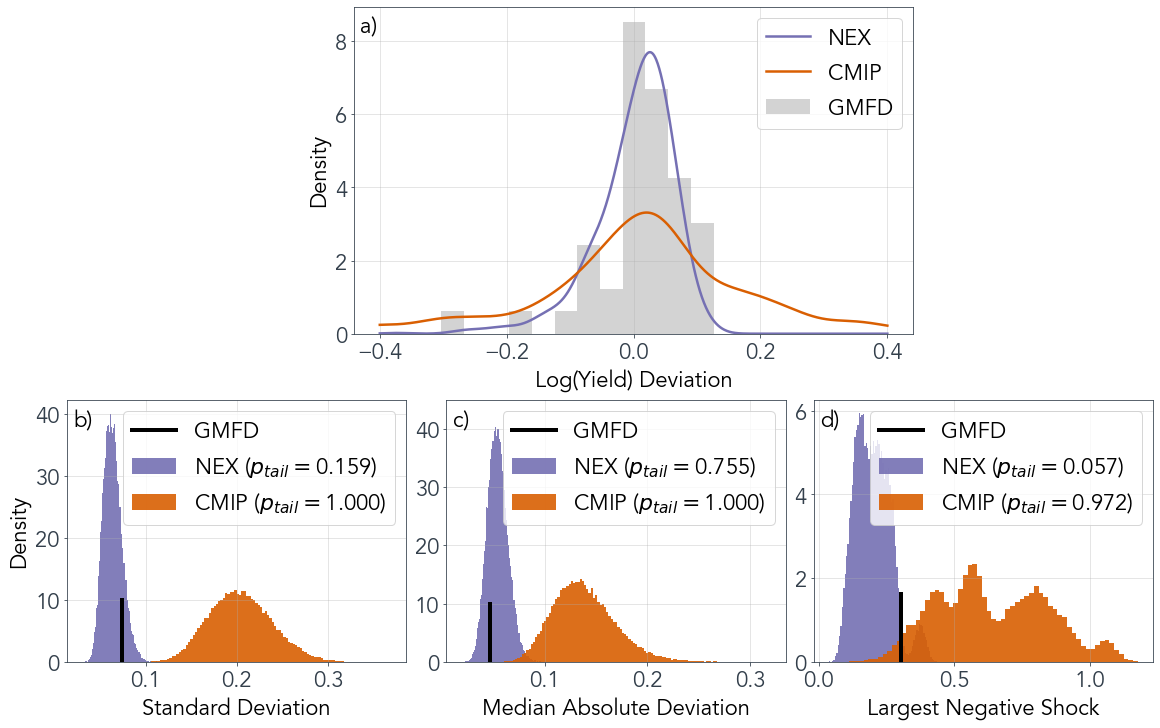

In [64]:
# Final
fig = plt.figure(figsize=(16,10), constrained_layout=True)
gs = gridspec.GridSpec(9, 9, figure=fig)

# PDF
ax1 = fig.add_subplot(gs[:5,2:-2])
xarr = np.linspace(-0.4,0.4,1000)
ax1.plot(xarr, np.exp(NEX_ens_pdf.score_samples(xarr[:,None])), label = 'NEX', color = '#7570b3', linewidth=2.5)
ax1.plot(xarr, np.exp(CMIP_ens_pdf.score_samples(xarr[:,None])), label = 'CMIP', color = '#d95f02', linewidth=2.5)
ax1.hist(GMFDens_w, label = 'GMFD', color = 'darkgray', density=True, alpha = 0.5, bins='fd')
ax1.legend()
ax1.set_xlabel('Log(Yield) Deviation')
ax1.set_ylabel('Density')
ax1.text(0.01, 0.92, 'a)', transform=ax1.transAxes)
ax1.grid(zorder=10, alpha=0.4)

# SD
ax2 = fig.add_subplot(gs[-4:, :3])
sampDist1 = np.array([np.std(x) for x in sampDist])
CsampDist1 = np.array([np.std(x) for x in CsampDist])
val = np.std(GMFDens_w)
nex_ecdf = ECDF(sampDist1)
cmip_ecdf = ECDF(CsampDist1)

ax2.hist(sampDist1, density=True,  label = 'NEX ($p_{tail}=$%0.3f)' % (1-nex_ecdf(val)), color = '#7570b3', alpha = 0.9, bins='auto')
ax2.hist(CsampDist1, density=True, label = 'CMIP ($p_{tail}=$%0.3f)' % (1-cmip_ecdf(val)), color = '#d95f02', alpha = 0.9, bins='auto')
ax2.plot([val,val], [0,10], linewidth=4, color = 'black', label = 'GMFD')
ax2.set_xlabel('Standard Deviation')
ax2.set_ylabel('Density')
ax2.text(0.02, 0.9, 'b)', transform=ax2.transAxes)
ax2.legend()
ax2.grid(zorder=10, alpha=0.4)

# MAD
ax3 = fig.add_subplot(gs[-4:, 3:6])
sampDist1 = np.array([ss.median_absolute_deviation(x) for x in sampDist])
CsampDist1 = np.array([ss.median_absolute_deviation(x) for x in CsampDist])
val = ss.median_absolute_deviation(GMFDens_w)
nex_ecdf = ECDF(sampDist1)
cmip_ecdf = ECDF(CsampDist1)

ax3.hist(sampDist1, density=True,  label = 'NEX ($p_{tail}=$%0.3f)' % (1-nex_ecdf(val)), color = '#7570b3', alpha = 0.9, bins='auto')
ax3.hist(CsampDist1, density=True, label = 'CMIP ($p_{tail}=$%0.3f)' % (1-cmip_ecdf(val)), color = '#d95f02', alpha = 0.9, bins='auto')
ax3.plot([val,val], [0,10], linewidth=4, color = 'black', label = 'GMFD')
ax3.set_xlabel('Median Absolute Deviation')
ax3.text(0.02, 0.9, 'c)', transform=ax3.transAxes)
ax3.legend()
ax3.grid(zorder=10, alpha=0.4)

# Min
ax4 = fig.add_subplot(gs[-4:, 6:])
sampDist1 = np.array([np.abs(np.min(x)) for x in sampDist])
CsampDist1 = np.array([np.abs(np.min(x)) for x in CsampDist])
val = np.abs(np.min(GMFDens_w))
nex_ecdf = ECDF(sampDist1)
cmip_ecdf = ECDF(CsampDist1)

ax4.hist(sampDist1, density=True,  label = 'NEX ($p_{tail}=$%0.3f)' % (1-nex_ecdf(val)), color = '#7570b3', alpha = 0.9, bins='auto')
ax4.hist(CsampDist1, density=True, label = 'CMIP ($p_{tail}=$%0.3f)' % (1-cmip_ecdf(val)), color = '#d95f02', alpha = 0.9, bins='auto')
ax4.plot([val,val], [0,1.63], linewidth=4, color = 'black', label = 'GMFD')
ax4.set_xlabel('Largest Negative Shock')
ax4.text(0.02, 0.9, 'd)', transform=ax4.transAxes)
ax4.legend()
ax4.set_xticks([0.0,0.5,1.0])
ax4.grid(zorder=0, alpha=0.4)

plt.show()